Tutorial taken from https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f

### How prediction machine learning problems are structured

    It is known as the one to many problem. The one to many problem starts like the one to one problem where we have an input to the model and the model generates one output. However, the output of the model is now fed back to the model as a new input. The model now can generate a new output and we can continue like this indefinitely. You can now see why these are known as recurrent neural networks

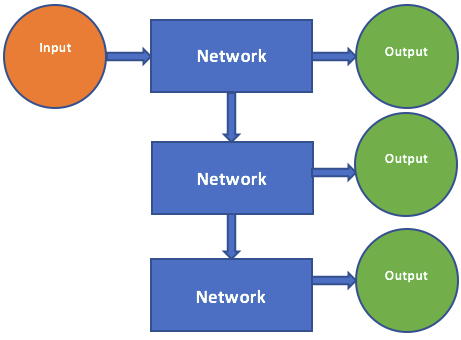

### Long Short-term Neural Network
    This model is organized in cells which include several operations. LSTM has an internal state variable, which is passed from one cell to another and modified by Operation Gates.
    
    1.  Forget Gate - It is a sigmoid layer that takes the output at t-1 and the current input at time t and concatenates them into a single tensor and applies a linear transformation followed by a sigmoid. Because of the sigmoid, the output of this gate is between 0 and 1. This number is multiplied with the internal state and that is why the gate is called a forget gate. If ft=0 then the previous internal state is completely forgotten, while if ft=1 it will be passed through unaltered.
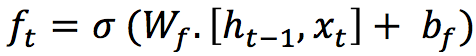

    


    2. Input Gate  -  
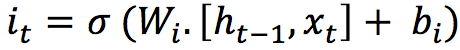
    
    The input gate takes the previous output and the new input and passes them through another sigmoid layer. This gate returns a value between 0 and 1. The value of the input gate is multiplied with the output of the candidate layer. This layer applies a hyperbolic tangent to the mix of input and previous output, returning a candidate vector to be added to the internal state.
    

    Candidate Layer:
    
   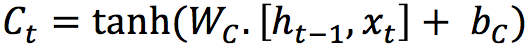

    The internal state is updated with this rule:
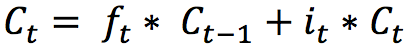

    .The previous state is multiplied by the forget gate and then added to the fraction of the new candidate allowed by the output gate.

    3. Output Gate- .The previous state is multiplied by the forget gate and then added to the fraction of the new candidate allowed by the output gate.
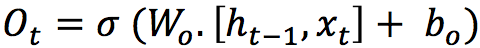

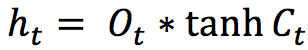

    These three gates described above have independent weights and biases, hence the network will learn how much of the past output to keep, how much of the current input to keep, and how much of the internal state to send out to the output.

# To summerize, by using a variation of neural networks that uses these gates to control input and output starting from the first input, the neural network can adapt and control what to learn from the new input and what to retain from the old input

### Using this tutorial to implement a multivariate forecaster (Our time series consists of two variables, price and signal)

Note this uses the Keras Deep Learning Library which requires Tensorflow

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


In [205]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## This is where we begin preprocessing our dataframe:

    This cell reads in the csv as a dataframe and denotes the column to use as the date index. dateparse is a function to convert Strings into Python datetime objects

In [206]:
#Prepare data, read in data and use date as index
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
df = pd.read_csv("stockdata.csv", index_col='date', parse_dates=['date'])

    This cell drops outliers and nan data from our dataframe.

In [207]:
#Drop empty rows and columns
df = df.dropna(how='any')
# Detect outliers in signal
sig_val = df['signal'].value_counts()
criteria = df[ (df['signal'] <= 2) | (df['signal'] >= 400) ]
df['signal'][criteria.index] = np.nan

# Detect outliers in price
sig_val = df['spy_close_price'].value_counts()
criteria = df[ df['spy_close_price'] >= 500 ]
df['spy_close_price'][criteria.index] = np.nan

#By replacing the outliers with nan, we are able to both drop nan data and outliers
df = df.dropna(how="any")
#Rename spy_close_price to price column for convenience
df.columns = ['signal', 'price']

    Initial plot of our signal with respect to time

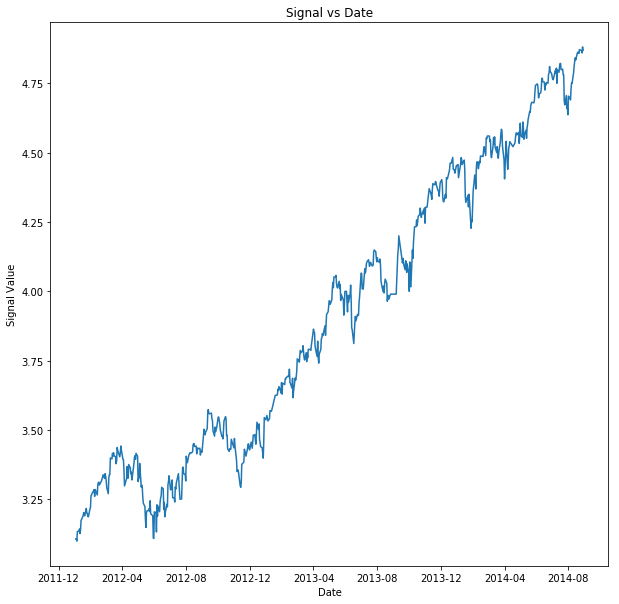

In [208]:
import matplotlib.pyplot as plt
#Plot both the signal
plt.figure(figsize=(10,10))
plt.title("Signal vs Date")
plt.ylabel("Signal Value")
plt.xlabel("Date")
plt.plot(df['signal'])
plt.show()

    Initial Plot of our price with respect to time

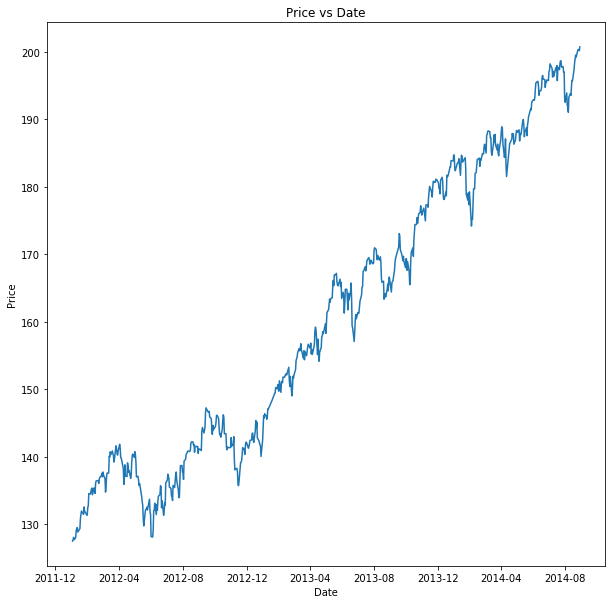

In [209]:
#plot price
plt.figure(figsize=(10,10))
plt.title("Price vs Date")
plt.ylabel("Price")
plt.xlabel("Date")
plt.plot(df['price'])
plt.show()

### Informal analysis demonstrates that both graphs show a similar trend and shape, suggesting a correlation between signal and price

# Framing this into a supervised deep learning problem:

    We want to frame this as trying to predict the subsequent price by supplying the previous price and the current signal as inputs.
    
### What do we need to do to the dataframe:

1. Normalize features by scaling using a MinMaxVector

2. Lag the signal column (the input value) with respect to our price column (the output value)

In [210]:
from sklearn.preprocessing import MinMaxScaler

#Get the column values as a 2D array
values = df.values
#Normalize the data (make variance == 1) by scaling each signal + price to a val between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values)

In [211]:
# Helpful function taken from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# The purpose of this function is to lag input with respect towards the output value.
# For our purposes, the signal will be lagged by one day with respect to the price.
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        #Shifts each column in the dataframe down by 1.
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

<font size=4>We use the above convenience function in order to properly model the signal+price dataframe as a supervised learning problem by lagging the signal with respect to the price. Our neural network takes as input signal + last price to predict the current price.</font>

In [212]:
lagged_dataframe = series_to_supervised(scaled_data)
#Drop current signal column, it is unneeded, we only need lagged signal. This is because we shifted our output column
#price down.
lagged_dataframe.drop(lagged_dataframe.columns[[2]], axis=1, inplace=True)
#More understandable column names
lagged_dataframe.columns = ['lagged_signal', 'last_price', 'current_price']

In [213]:


#Split into training and test sets

values = lagged_dataframe.values
#Use 75% of our data

n_train_hours = int(.75 * len(values))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
# train X consists of lagged signal + last price as input and current price as output.
# The third dimension is used to represent a timestep which is consistent among our dataset as a day.
# This is required for our neural network
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

## Having finally properly processed our data to be compatible, we fit the LSTM Neural network to our data

In [214]:
# neural network
model = Sequential()
#Use the Long Short Term Memory NN
#input is (lagged signal, price)
model.add(LSTM(50, input_shape=(train_X.shape[1],train_X.shape[2])))
#Add a dense layer
model.add(Dense(1))
#Loss is calculated using Mean Absolute Error (mae).
model.compile(loss='mae', optimizer='adam')
# fit network and run 100 epochs of learning on the network.
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 492 samples, validate on 165 samples
Epoch 1/100
 - 2s - loss: 0.3125 - val_loss: 0.8015
Epoch 2/100
 - 0s - loss: 0.2790 - val_loss: 0.7491
Epoch 3/100
 - 0s - loss: 0.2459 - val_loss: 0.6952
Epoch 4/100
 - 0s - loss: 0.2140 - val_loss: 0.6402
Epoch 5/100
 - 0s - loss: 0.1845 - val_loss: 0.5844
Epoch 6/100
 - 0s - loss: 0.1596 - val_loss: 0.5302
Epoch 7/100
 - 0s - loss: 0.1404 - val_loss: 0.4786
Epoch 8/100
 - 0s - loss: 0.1284 - val_loss: 0.4335
Epoch 9/100
 - 0s - loss: 0.1211 - val_loss: 0.3945
Epoch 10/100
 - 0s - loss: 0.1154 - val_loss: 0.3607
Epoch 11/100
 - 0s - loss: 0.1108 - val_loss: 0.3308
Epoch 12/100
 - 0s - loss: 0.1062 - val_loss: 0.3033
Epoch 13/100
 - 0s - loss: 0.1019 - val_loss: 0.2777
Epoch 14/100
 - 0s - loss: 0.0978 - val_loss: 0.2539
Epoch 15/100
 - 0s - loss: 0.0942 - val_loss: 0.2325
Epoch 16/100
 - 0s - loss: 0.0907 - val_loss: 0.2134
Epoch 17/100
 - 0s - loss: 0.0873 - val_loss: 0.1963
Epoch 18/100
 - 0s - loss: 0.0840 - val_loss: 0.1815
Epoch 19/

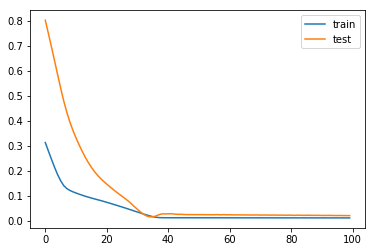

In [215]:
#Show important statistics regarding the NN
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## We can see from this plot how the LSTM Neural network is able to reduce loss by adapting with each successive epoch

## Both the train and test sets are able to improve in prediction based on signal. Given how the loss in both sets begins to drop significantly.

### Now we actually want to test the predictive ability of the Neural network. First we need to retrieve predicted values and test values

In [216]:
#Get predicted prices
predicted = model.predict(test_X)
#We want to reverse the minmax scalar to get the "true" value of the prediction
#To do so, we must get rid of time step which was added to allow the neural network to function
reverse_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#This concatenates our predicted values for the price with the associated signal
reverse_Y = np.concatenate((reverse_X[:, 1:],predicted), axis=1)
#Reverse the transformation of the min-max scalar
unscaled_prediction = scaler.inverse_transform(reverse_Y)
unscaled_prediction = unscaled_prediction[:,1]
#Here are the predicted prices
print(unscaled_prediction)

[184.76951005 184.76951005 183.81109409 182.55347235 184.16124031
 184.67148691 184.62091741 184.51607778 183.40055075 184.57871361
 184.39278299 182.33704205 181.46319953 182.29071432 181.51208018
 181.58826609 178.88460889 176.43168268 177.61770066 176.55125502
 178.73238545 179.22099993 178.1407511  178.77835097 177.69508229
 180.45920207 182.19245989 182.19245989 182.19245989 182.99613876
 183.57816368 184.00463982 185.07677169 185.16640294 184.48304265
 185.57054    185.68369297 185.61355986 186.85680674 186.80323484
 187.55510048 187.82092638 187.08007972 188.14329167 188.35413611
 187.55892767 187.34704897 188.11623515 188.24786946 187.78186899
 187.13146091 186.07418394 186.63740022 187.82369313 186.59661034
 187.01777991 186.59360357 186.90897344 188.01899753 187.57200644
 187.22798285 186.64175981 186.48308207 185.78476214 186.95304938
 187.77361239 187.49681988 184.28639851 185.33606039 187.41008629
 185.31793689 184.70929621 187.09600379 187.75243848 188.66575298
 188.69369

In [217]:
#Perform the same reversal on the true_price values from test
true_price_scaled = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((reverse_X[:, 1:],true_price_scaled), axis=1)
true_price_unscaled = scaler.inverse_transform(inv_y)
true_price_unscaled = true_price_unscaled[:,1]
print(true_price_unscaled)

[184.69   182.885  182.36   183.48   183.52   183.64   184.14   181.685
 183.67   184.66   184.42   183.635  184.18   184.3    182.79   178.89
 178.01   179.07   177.35   179.23   178.18   174.17   175.385  175.17
 177.48   179.68   179.68   179.68   181.98   182.07   183.01   184.02
 184.24   183.02   184.1    183.89   184.91   184.84   184.85   185.82
 186.29   184.98   187.58   187.75   188.18   188.26   188.16   187.23
 187.28   185.18   184.66   186.33   187.66   186.66   187.747  186.2
 185.43   186.31   184.97   184.58   185.49   187.01   188.25   188.88
 188.63   186.4    184.34   185.1    187.09   183.155  181.51   186.39
 187.04   187.89   187.45   187.83   186.29   186.875  187.75   188.31
 188.325  188.06   188.42   186.78   187.88   187.675  187.96   189.785
 189.96   189.06   187.4    188.05   188.74   187.55   189.13   189.59
 190.35   191.52   191.38   192.37   192.68   192.895  192.8    193.19
 194.45   195.375  195.58   195.6    194.92   193.54   194.13   194.29
 194.

In [218]:
#Get Root Mean Squared Error
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(true_price_unscaled,unscaled_prediction))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.797


## Explaination of RMSE:

    The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance, and has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and is the most important criterion for fit if the main purpose of the model is prediction.
    
https://www.theanalysisfactor.com/assessing-the-fit-of-regression-models/


In [219]:
print("VARIANCE OF THE TRUE PRICE: ", np.var(true_price_unscaled))

VARIANCE OF THE TRUE PRICE:  38.82038576235227


In [220]:
print("VARIANCE OF THE PREDICTED PRICE: ", np.var(unscaled_prediction))

VARIANCE OF THE PREDICTED PRICE:  42.48452056622883


Note that the RMSE is much smaller than the variances of both of the data sets used to calculate it, this implies that our prediction was very close to the true results, thus we can conclude that the signal does have a significant, predicative factor in predicting stock market prices!

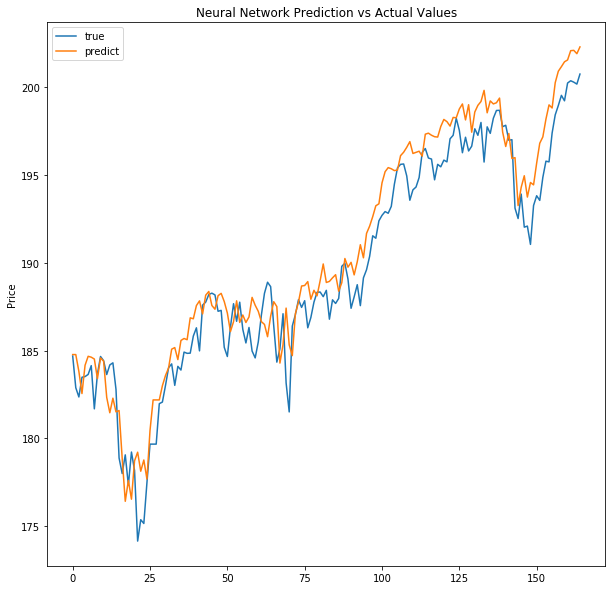

In [221]:
plt.figure(figsize=(10,10))
plt.plot(true_price_unscaled, label="true")
plt.plot(unscaled_prediction, label="predict")
plt.ylabel("Price")
plt.title("Neural Network Prediction vs Actual Values")
plt.legend()
plt.show()

# R^2 metric

We calculate the r^2 score because we used regression to solve this problem using Neural Networks. The r^2 score is used to evaluate the quality and accuracy of out prediction.

In [222]:
from sklearn.metrics import r2_score
#Get r2 score
print("R2 SCORE: ", r2_score(true_price_unscaled, unscaled_prediction))

R2 SCORE:  0.9168359559362429


## Because of the relatively high r2_score, (complete accuracy is 1.0) we can conclude that this neural network is able to accurately predict future stock prices based on the signal and current price. Thus, the signal is predicative of stock prices

# Part 2, using stationary data with recurring neural networks

### This is a redo of this analysis with LSTM Neural networks, using stationary data in order to perhaps recieve better results. As such, many of the steps must be repeated in order to get our final result, skip to the bottom to see the results.

In [171]:
#Reload data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
df = pd.read_csv("stockdata.csv", index_col='date', parse_dates=['date'])

In [172]:
#Drop empty rows and columns
df = df.dropna(how='any')
# Detect outliers in signal
sig_val = df['signal'].value_counts()
criteria = df[ (df['signal'] <= 2) | (df['signal'] >= 400) ]
df['signal'][criteria.index] = np.nan

# Detect outliers in price
sig_val = df['spy_close_price'].value_counts()
criteria = df[ df['spy_close_price'] >= 500 ]
df['spy_close_price'][criteria.index] = np.nan

#By replacing the outliers with nan, we are able to both drop nan data and outliers
df = df.dropna(how="any")
#Replace price column name for convenience
df.columns = ['signal', 'price']

## Now we will make this dataset stationary, the specific process is described in our ARIMA analysis, however, I will be using a different approach by using the decomposing method.

In [173]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
# Log transformation in order to reduce trend, this is because higher values are penalized.
signal_log = np.log(df['signal'])
price_log = np.log(df['price'])
#Now we use seasonal_decompose to extract seasonality and remaining trend retain the residuals to use in our data
decomposition = seasonal_decompose(signal_log,freq=30)
#Retrieve the residuals
signal_residual = decomposition.resid
decomposition = seasonal_decompose(price_log,freq=30)
price_residual = decomposition.resid

    Plot Stationary Data. First the signal.

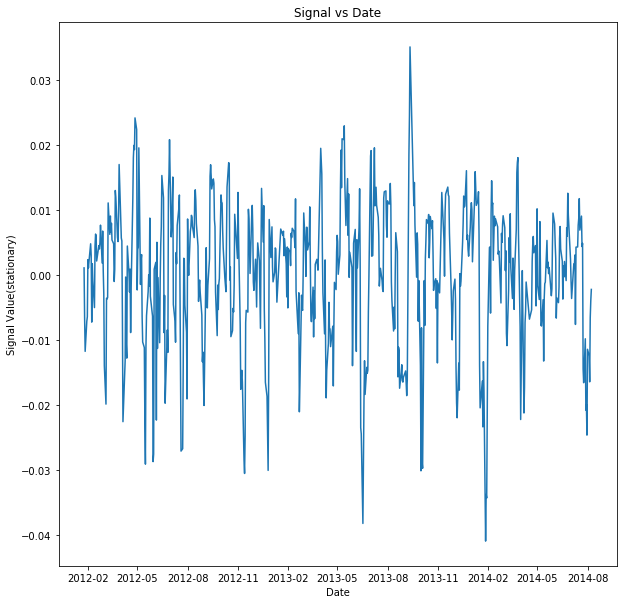

In [174]:
#Plot stationary signal
plt.figure(figsize=(10,10))
plt.title("Signal vs Date")
plt.ylabel("Signal Value(stationary)")
plt.xlabel("Date")
plt.plot(signal_residual)
plt.show()

    Now we plot the stationary prices.

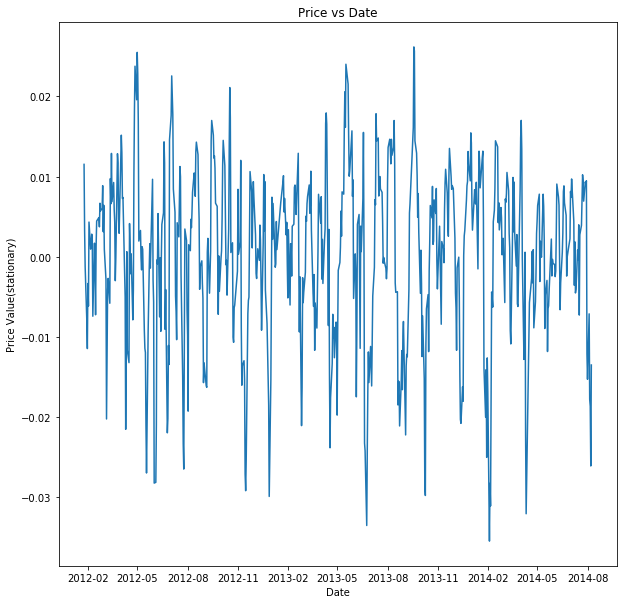

In [175]:
plt.figure(figsize=(10,10))
plt.title("Price vs Date")
plt.ylabel("Price Value(stationary)")
plt.xlabel("Date")
plt.plot(price_residual)
plt.show()

## As we can see, both graphs do not express an upwards trend unlike the first part. This is a good sign that we now have a stationary dataset.

## Now we simply repeat the steps to process the data and fit the neural network to it. Again this involves normalizing the data, lagging the time series, and converting it to a 3 dimensional dataset. Thus, navigate to the neural network analysis since the preprocessing has already been explained

In [192]:
#from sklearn.preprocessing import MinMaxScaler

stationarydf = pd.concat([signal_residual, price_residual], axis=1)
#Drop nan values
stationarydf.dropna(how="any", inplace=True)
scaled_data = stationarydf.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(scaled_data)

In [193]:
# Helpful function taken from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# The purpose of this function is to lag input with respect towards the output value.
# For our purposes, the signal will be lagged by one day with respect to the price.
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [194]:
lagged_stationary_df= series_to_supervised(scaled_data)
#Drop current signal column, it is unneeded
lagged_stationary_df.drop(lagged_stationary_df.columns[[2]], axis=1, inplace=True)
lagged_stationary_df.columns = ['lagged_signal', 'last_price', 'current_price']

In [195]:

#Split into training and test sets

values = lagged_stationary_df.values
#Use 75% of our data

n_train_hours = int(.75 * len(values))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
# This is required for our neural network
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [196]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# neural network
model = Sequential()
#Use the Long Short Term Memory NN
#input is time step, (lagged signal, price)
model.add(LSTM(50, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 470 samples, validate on 157 samples
Epoch 1/100
 - 1s - loss: 0.5516 - val_loss: 0.5295
Epoch 2/100
 - 0s - loss: 0.5051 - val_loss: 0.4828
Epoch 3/100
 - 0s - loss: 0.4573 - val_loss: 0.4350
Epoch 4/100
 - 0s - loss: 0.4078 - val_loss: 0.3850
Epoch 5/100
 - 0s - loss: 0.3560 - val_loss: 0.3330
Epoch 6/100
 - 0s - loss: 0.3022 - val_loss: 0.2782
Epoch 7/100
 - 0s - loss: 0.2478 - val_loss: 0.2213
Epoch 8/100
 - 0s - loss: 0.1930 - val_loss: 0.1671
Epoch 9/100
 - 0s - loss: 0.1428 - val_loss: 0.1220
Epoch 10/100
 - 0s - loss: 0.1083 - val_loss: 0.0960
Epoch 11/100
 - 0s - loss: 0.0955 - val_loss: 0.0931
Epoch 12/100
 - 0s - loss: 0.0971 - val_loss: 0.0944
Epoch 13/100
 - 0s - loss: 0.0975 - val_loss: 0.0928
Epoch 14/100
 - 0s - loss: 0.0949 - val_loss: 0.0918
Epoch 15/100
 - 0s - loss: 0.0937 - val_loss: 0.0923
Epoch 16/100
 - 0s - loss: 0.0936 - val_loss: 0.0923
Epoch 17/100
 - 0s - loss: 0.0932 - val_loss: 0.0916
Epoch 18/100
 - 0s - loss: 0.0927 - val_loss: 0.0911
Epoch 19/

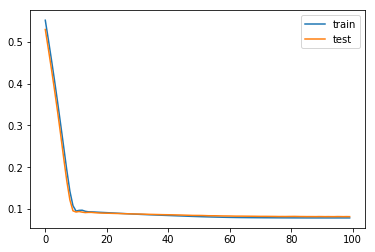

In [197]:
#Show important statistics regarding the NN
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Notably, by making the data stationary, the LTSM neural network is able to reduce loss at a faster rate in both the training and test datasets, than with the non-stationary dataset. However, it seems to remain at a loss of 0.1 which is not much better than the stationary dataset

In [198]:
#Evaluate predictive ability
predicted = model.predict(test_X)
#We want to reverse the minmax scalar to get the "true" value of the prediction
#To do so, we must get rid of time step which was added to allow the neural network to function
reverse_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
#This concatenates our predicted values for the price with the associated signal
reverse_Y = np.concatenate((reverse_X[:, 1:],predicted), axis=1)
unscaled_prediction = scaler.inverse_transform(reverse_Y)
unscaled_prediction = unscaled_prediction[:,1]
print(unscaled_prediction)

[ 5.33602395e-03  9.50925471e-03  7.66675366e-03  8.22775367e-03
  1.01540230e-02  8.81563051e-03  8.64725629e-03  1.36262591e-02
  1.30500956e-02  7.42946968e-03  2.92373419e-03  9.25988259e-03
  9.25975032e-03  8.40140773e-03  9.50410347e-03  2.31716298e-03
  9.31060869e-03  1.08749208e-02  4.18226041e-03  4.89646069e-05
  3.74144004e-03  2.20616151e-03 -5.44831379e-04 -1.33642049e-02
 -2.25278826e-02 -1.74588113e-02 -2.37849502e-02 -1.31687572e-02
 -1.26726713e-02 -2.08952982e-02 -1.66218397e-02 -2.06839340e-02
 -8.93461731e-03  1.22399814e-03 -2.97586623e-04 -9.76190662e-04
  3.69784190e-03  6.60813371e-03  8.06377748e-03  1.25072425e-02
  1.16083624e-02  3.88276842e-03  5.71202763e-03  3.10268278e-03
  3.01435484e-03  5.21223991e-03  1.70395616e-03  3.65027561e-03
  4.24241085e-03 -1.63428160e-03  5.16279610e-03  5.75884805e-03
  2.82410071e-03  4.05217142e-03  4.98199571e-03  3.70142792e-03
  1.43292091e-03 -3.35280387e-03 -6.62491141e-03  5.46268561e-04
  7.54738969e-03  1.39459

In [199]:
#Reverse true prices
true_price_scaled = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((reverse_X[:, 1:],true_price_scaled), axis=1)
true_price_unscaled = scaler.inverse_transform(inv_y)
true_price_unscaled = true_price_unscaled[:,1]
print(true_price_unscaled)

[ 7.04262025e-03  8.84998921e-03  9.37388035e-03  1.31179131e-02
  1.16061155e-02  9.45826286e-03  1.54448174e-02  1.41789661e-02
  6.54914513e-03  3.31365152e-03  8.36195646e-03  6.74776312e-03
  6.56575229e-03  9.28061164e-03 -1.52341181e-03  8.11433618e-03
  1.31602269e-02  1.20048818e-02  8.58570550e-03  1.24086733e-02
  1.31662978e-02  4.61007928e-03 -1.38743249e-02 -2.00142417e-02
 -1.40916453e-02 -2.50309594e-02 -1.26275330e-02 -1.68095288e-02
 -3.54762217e-02 -2.82674104e-02 -3.10981532e-02 -1.78533647e-02
 -4.40393677e-03 -5.13252277e-03 -6.28895994e-03  4.36464865e-03
  5.78184810e-03  8.53323030e-03  1.44577817e-02  1.37033410e-02
  4.24938244e-03  6.72813456e-03  3.33942498e-03  6.13438491e-03
  4.85852908e-03  2.35120002e-04  1.95295328e-03  2.29005926e-03
 -5.72099567e-03  7.20256932e-03  6.78962128e-03  7.84236962e-03
  1.05069047e-02  8.22488213e-03  2.90212826e-03  1.12640935e-03
 -9.21103829e-03 -1.08852678e-02  2.13120492e-03  9.88532481e-03
  3.10766456e-03  9.30910

In [200]:
#Get Root Mean Squared Error
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(true_price_unscaled,unscaled_prediction))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.007


In [201]:
print("VARIANCE OF THE TRUE PRICE: ", np.var(true_price_unscaled))

VARIANCE OF THE TRUE PRICE:  9.962550419800402e-05


In [202]:
print("VARIANCE OF THE PREDICTED PRICE: ", np.var(unscaled_prediction))

VARIANCE OF THE PREDICTED PRICE:  5.4250479423161e-05


### Our root mean squared error is significant compared to the variance of the prices, this implies that our neural network predicted more inaccurate results than by just simply using the non-stationary dataset.

## R^2 score

In [203]:
print(r2_score(true_price_unscaled,unscaled_prediction))

0.5622360447471801


### The lower r^2 score confirms this, this regression is significantly less accurate than simply analyzing the non-stationary dataset as the neural network is unable to fit a prediction that is as accurate as the unprocessed dataset.

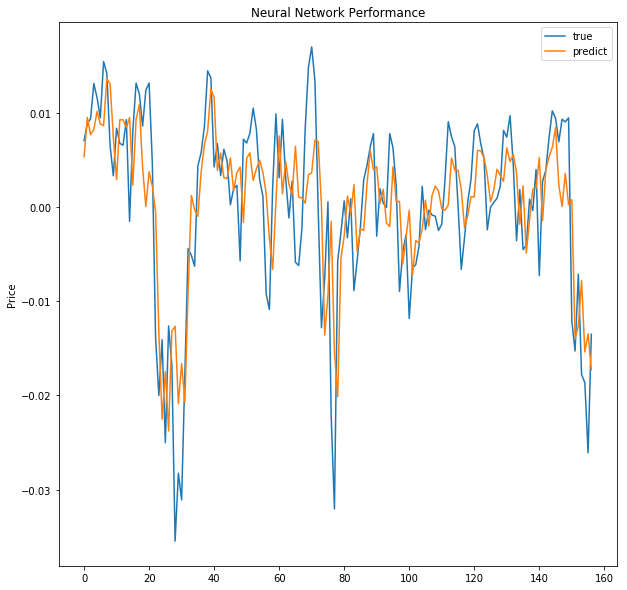

In [204]:
plt.figure(figsize=(10,10))
plt.plot(true_price_unscaled, label="true")
plt.plot(unscaled_prediction, label="predict")
plt.ylabel("Price")
plt.title("Neural Network Performance")
plt.legend()
plt.show()

## What can we conclude?:

It appears by stationarizing our data, the resultant graph still remains relatively accurate in predicting the true value. It certainly appears as a better fit than simply using an ordinary neural network. However, it is a worse fit than simply using the original dataset with trend and seasonality. The main reason why this could have happened would be floating point error. Any small discrepency in the data caused by it would be exaggerated due to the small scale of our stationary data after removing trend and seasonality